# Подбор гиперпараметров модели с помощью Hyperopt¶

В машинном обучении гиперпараметрами называют параметры модели, значения которых устанавливаются перед запуском процесса её обучения. Ими могут быть, как параметры самого алгоритма, например, глубина дерева в random forest, число соседей в knn, так и способы обработки признаков, пропусков и т.д. Они используются для управления процессом обучения, поэтому подбор оптимальных гиперпараметров – очень важный этап в построении ML-моделей, позволяющий повысить точность, а также бороться с переобучением. На сегодняшний день существуют несколько популярных подходов к решению задачи подбора:

__1. Поиск по решётке.__ В этом способе значения гиперпараметров задаются вручную, затем выполняется их полный перебор. Популярной реализацией этого метода является Grid Search из sklearn. Несмотря на свою простоту этот метод имеет и серьёзные недостатки:

 - Очень медленный т.к. надо перебрать все комбинации всех параметров. Притом перебор будет продолжаться даже при заведомо неудачных комбинациях.

 - Часто в целях экономии времени приходится укрупнять шаг перебора, что может привести к тому, что оптимальное значение параметра не будет найдено. Например, если задан диапазон значений от 100 до 1000 с шагом 100 (примером такого параметра может быть количество деревьев в случайном лесе, или градиентном бустинге), а оптимум находится около 550, то GridSearch его не найдёт.

__2. Случайный поиск.__ Здесь параметры берутся случайным образом из выборки с указанным распределением. В sklearn он этот метод реализован как [Randomized Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). В большинстве случаев он быстрее GridSearch, к тому же значения параметров не ограничены сеткой. Однако, даже это не всегда позволяет найти оптимум и не защищает от перебора заведомо неудачных комбинаций.

__3. [Байесовская оптимизация](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f).__ Здесь, в отличии от предыдущих методов, значения гиперпараметров в текущей итерации выбираются с учётом результатов на предыдущем шаге. Основная идея алгоритма заключается в следующем – на каждой итерации подбора находится компромисс между исследованием регионов с самыми удачными из найденных комбинаций гиперпараметров и исследованием регионов с большой неопределённостью (где могут находиться ещё более удачные комбинации). Это позволяет во многих случаях найти лучшие значения параметров модели за меньшее количество времени так как алгоритм старается сосредоточится именно на самых перспективных регионах. Принцип работы алгоритма следующий:

   1. Для целевой функции построить суррогатную функцию $P(score|hyperparameters)$ (такую функцию удобнее оптимизировать). 
   2. Найти гиперпараметры с самым лучшим результатом на этой суррогатной функции.
   3. Найти значение целевой функции для найденных гиперпараметров.
   4. Обновить суррогатную функцию с учётом результатов п. 3. 
   5. Повторять п. 2-4 до достижения критерия останова. 
   
В этой статье приведён обзор [hyperopt](https://hyperopt.github.io/hyperopt/) – популярной python-библиотеки для подбора гиперпарметров. В ней реализовано 3 алгоритма оптимизации: классический Random Search, метод байесовской оптимизации [Tree of Parzen Estimators](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) (TPE), и Simulated Annealing – [метод имитации отжига](https://habr.com/ru/post/209610/).

Установить hyperopt очень просто:

`pip install hyperopt`

Оценим работу этой библиотеки в реальной [задаче](https://archive.ics.uci.edu/ml/datasets/Adult) – предсказать, зарабатывает ли человек больше $50 тыс. Загрузим необходимые библиотеки, и подготовим данные на вход модели:

In [1]:
from functools import partial
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context("talk")

# random state
RS = 1

# загружаем данные
df = pd.read_csv(r'..\adult.data.csv')

# удаляем дубликаты
df.drop_duplicates(inplace=True, ignore_index=True)

# готовим признаки и целевую переменную 
X = df.drop(labels=['salary', 'native-country'], axis=1).copy()
y = df['salary'].map({'<=50K':0,'>50K':1}).values

В данных есть признаки разных типов, которые, соответственно, требуют и разной обработки. Для этого воспользуемся методом [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) из библиотеки sklearn, который позволяет задать свой способ обработки для каждой группы признаков. Для категориальных признаков (тип object) будем использовать методы `SimpleImputer` (заменяет пропуски, которые обозначены символом "?") и `OneHotEncoder` (выполняет dummy-кодирование). Числовые признаки (остальные типы) будем масштабировать с помощью `StandardScaler`. В качестве классификатора выберем логистическую регрессию.

In [2]:
# выбираем категориальные (тип object)
# и численные признаки (остальные типы)
num_columns = np.where(X.dtypes != 'object')[0]
cat_columns = np.where(X.dtypes == 'object')[0]

# пайплайн для категориальных признаков
cat_pipe = Pipeline([('imputer', SimpleImputer(missing_values='?', 
                                               strategy='most_frequent')),
                     ('ohe', OneHotEncoder(sparse=False, 
                                           handle_unknown='ignore'))])

# пайплайн для численных признаков
num_pipe = Pipeline([('scaler', StandardScaler())])

# соединяем пайплайны вместе
transformer = ColumnTransformer(
                           transformers=[('cat', cat_pipe, cat_columns),
                                         ('num', num_pipe, num_columns)], 
                           remainder='passthrough') 
# итоговая модель
model = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=RS, 
                                            solver='liblinear'))])

Укажем пространство поиска параметров. Hyperopt позволяет работать с параметрами разного типа – непрерывными, дискретными, категориальными:  

In [3]:
search_space = {
                'lr__penalty' : hp.choice(label='penalty', 
                                          options=['l1', 'l2']),
                'lr__C' : hp.loguniform(label='C', 
                                        low=-4*np.log(10), 
                                        high=2*np.log(10))
                }

Здесь параметр регуляризации $C$ выбирается из лог-равномерного распределения $[- 4ln10, 2ln10]$, и может принимать значения $[10^{-4}, 10^{2}]$, а тип регуляризации равновероятно выбирается из $[l1, l2]$. Можно выбрать и [другие](https://github.com/hyperopt/hyperopt/wiki/FMin#21-parameter-expressions) типы распределений, например, равномерное, или нормальное.

Укажем функцию, которую будем оптимизировать. Она принимает на вход гиперпараметры, модель и данные, после чего возвращает точность на кросс-валидации (заметим, что точность возвращается со знаком минус т.к. мы минимизируем функцию):

In [4]:
def objective(params, pipeline, X_train, y_train, r_state=None):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём параметры модели      
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=r_state)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            scoring='roc_auc', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

Укажем объект для сохранения истории поиска ([Trials](https://github.com/hyperopt/hyperopt/wiki/FMin#13-the-trials-object)). Это очень удобно, т.к. сам процесс можно сохранять, и, по необходимости, возобновлять с места сохранения. Подбор выполняется с помощью функции fmin. Укажем в качестве алгоритма поиска tpe.suggest – байесовскую оптимизацию (для Random Search нужно указать tpe.rand.suggest).

In [5]:
# запускаем hyperopt
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=model, X_train=X, y_train=y, r_state=RS),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(RS),
          # progressbar
            show_progressbar=True
          )

100%|███████████████████████████████████████████████| 40/40 [03:08<00:00,  4.70s/trial, best loss: -0.9053253823577864]


Выведем результаты в pandas DataFrame с помощью специальной функции и визуализируем:

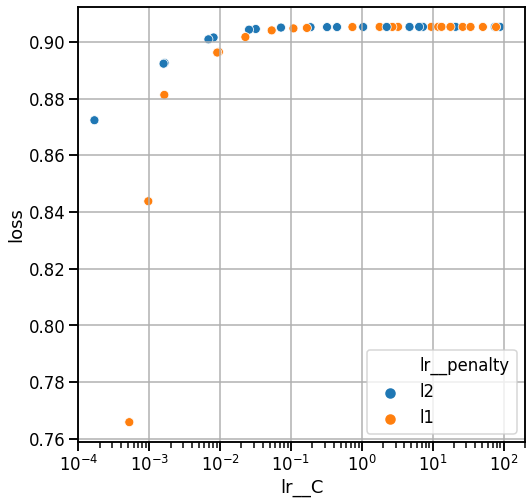

In [6]:
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 

    :hp_results: результаты hyperopt
    :return: DataFrame c результатами
    """ 

    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.loc[:, 'loss'] = results['loss'] * (-1)
    results.sort_values(by=['loss'], ascending=False, inplace=True, ignore_index=True)
    return results

results_hp = df_results(trials.results)
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='lr__C', y='loss', hue='lr__penalty', data=results_hp);
ax.set_xscale('log')
ax.set_xlim(1e-4, 2e2)
ax.grid()

На графике видно, что hyperopt почти не исследовал районы, где получались низкие значения roc auc, а сосредоточился на районах с наибольшими значениями этой метрики.

С hyperopt можно одновременно исследовать несколько моделей. Покажем это на простом примере для трёх классификаторов - логистической регрессии, дерева решений и метода ближайших соседей.  Изменим пространство поиска следующим образом - для каждого типа классификатора обозначим свой набор гиперпараметров:

In [7]:
search_space = {'clf_type': hp.choice(
                label='clf_type', 
                options=[{'type': 'lr', 
                          'params':{
                                    'penalty': hp.choice(label='penalty', 
                                                         options=['l1', 'l2']),
                                     'C': hp.loguniform(label='C', 
                                                        low=-4*np.log(10), 
                                                        high=2*np.log(10))
                                    }
                          }, 
                      
                          {'type': 'dt', 
                           'params':{
                                     'max_depth': scope.int(hp.uniform(label='max_depth', 
                                                                       low=4, high=15)),    
                                     'max_features': hp.uniform(label='max_features', 
                                                                low=0.25, high=0.9)
                                    }
                          },
                     
                          {'type': 'knn', 
                           'params':{
                                     'n_neighbors': scope.int(hp.uniform(label='n_neighbors', 
                                                                         low=10, high=31)),
                                     'p' : scope.int(hp.uniform(label='p', 
                                                                low=1, high=5)),
                                     }
                          }  
                    ])}

Модифицируем целевую функцию и напишем скрипт для построения модели с указанными гиперпараметрами: 

In [8]:
def buld_model(parameters, feat_transformer, r_state):
    """
    Формируем модель с указанными гиперпараметрами 
    
    :parameters: параметры
    :feat_transformer: column transformer для модели
    :r_state: random state
    :return: модель
    """ 
    
    if parameters['clf_type']['type'] == 'lr':
        classifier = LogisticRegression(random_state=r_state, solver='liblinear', 
                                        **parameters['clf_type']['params'])
    
    elif parameters['clf_type']['type'] == 'dt':
        classifier = DecisionTreeClassifier(random_state=r_state,
                                            **parameters['clf_type']['params'])
        
    elif parameters['clf_type']['type'] == 'knn':
        classifier = KNeighborsClassifier(n_jobs=-1, 
                                          **parameters['clf_type']['params'])
    else: 
        raise KeyError('Unknown classifier: {}'.format(parameters['clf_type']['type']))
    
    # pipeline с трансформером для признаков и классификатором
    model = Pipeline([('transformer', feat_transformer),
                      ('clf', classifier)])
    return model

# target function
def objective(parameters, feat_transformer, X_train, y_train, r_state):
    """
    Кросс-валидация с текущими гиперпараметрами
    
    :param params: гиперпараметры
    :feat_transformer: column transformer для модели
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :r_state: random state
    :return: средняя точность на кросс-валидации
    """     
    model = buld_model(parameters=parameters, feat_transformer=feat_transformer, r_state=r_state)     
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=r_state)
    score = cross_val_score(estimator=model, X=X_train, y=y_train, 
                            cv=skf, scoring='roc_auc', n_jobs=-1)
    
    return {'loss': -score.mean(), 'params': parameters['clf_type']['params'], 
            'clf':parameters['clf_type']['type'], 'status': STATUS_OK}

In [9]:
trials = Trials()
best = fmin(fn=partial(objective, feat_transformer=transformer, X_train=X, y_train=y, r_state=RS),
            space=search_space,
            algo=tpe.suggest,
            max_evals=40,
            trials=trials,
            rstate=np.random.RandomState(RS),
            show_progressbar=True
    )

100%|████████████████████████████████████████████████| 40/40 [11:25<00:00, 17.13s/trial, best loss: -0.905325056708917]


In [10]:
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 
    
    :hp_results: результаты hyperop
    :return: pandas DataFrame
    """ 
    
    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.loc[:, 'loss'] = results['loss'] * (-1)
    results.sort_values(by=['loss'], ascending=False, inplace=True, ignore_index=True)
    return results

# df с результатами для всех классификаторов
results_hp = df_results(trials.results)
results_hp.head()

,loss,clf,C,penalty,n_neighbors,p,max_depth,max_features
31,0.905325,lr,38.071405,l2,NaN,NaN,NaN,NaN
33,0.905323,lr,34.170335,l2,NaN,NaN,NaN,NaN
27,0.905321,lr,46.008608,l2,NaN,NaN,NaN,NaN
25,0.905320,lr,10.747004,l2,NaN,NaN,NaN,NaN
24,0.905319,lr,10.090087,l2,NaN,NaN,NaN,NaN
8,0.905317,lr,8.916779,l2,NaN,NaN,NaN,NaN
21,0.905317,lr,8.876809,l2,NaN,NaN,NaN,NaN
22,0.905314,lr,75.102608,l2,NaN,NaN,NaN,NaN
28,0.905312,lr,94.346590,l2,NaN,NaN,NaN,NaN
23,0.905311,lr,7.051203,l2,NaN,NaN,NaN,NaN


Таким образом, hyperopt – мощный инструмент для настройки модели, которым легко и удобно пользоваться. Дополнительные материалы можно найти в [1](https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_russian/tutorials/hyperopt_tutorial_stalkermustang%20.ipynb), [2](https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb), [3](https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Kaggle%20Version%20of%20Bayesian%20Hyperparameter%20Optimization%20of%20GBM.ipynb) и [4]().